In [ ]:
Module 1: Latent Space Representation



In [ ]:
!pip install torch torchvision matplotlib seaborn scikit-learn
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
#Build a Basic Autoencoder (AE)
#Define AE architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
#Train the Autoencoder
transform = transforms.ToTensor()
train_loader = DataLoader(datasets.MNIST('.', train=True, download=True, transform=transform),
                          batch_size=64, shuffle=True)


model = Autoencoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []
for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, 28*28)
        output = model(x)
        loss = criterion(output, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 11.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 334kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.36MB/s]


Epoch 1, Loss: 0.1727
Epoch 2, Loss: 0.1099
Epoch 3, Loss: 0.0979
Epoch 4, Loss: 0.0927
Epoch 5, Loss: 0.0895
Epoch 6, Loss: 0.0875
Epoch 7, Loss: 0.0860
Epoch 8, Loss: 0.0847
Epoch 9, Loss: 0.0837
Epoch 10, Loss: 0.0830


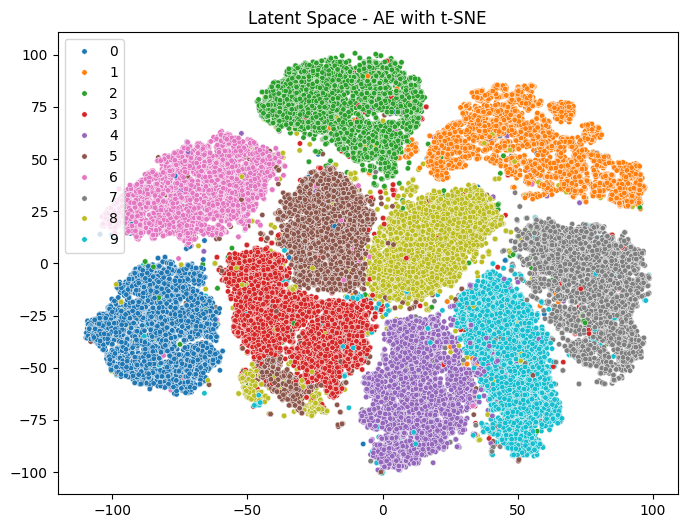

In [ ]:
#Visualize Latent Space with PCA/t-SNE
# Extract encoded representations
model.eval()
latents, labels = [], []
with torch.no_grad():
    for x, y in train_loader:
        x = x.view(-1, 28*28)
        z = model.encoder(x)
        latents.append(z)
        labels.append(y)
latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

# Visualize with t-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(latents)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=labels, palette='tab10', s=15)
plt.title("Latent Space - AE with t-SNE")
plt.savefig("latent_plot.png")
plt.show()


In [ ]:
#replace AE with Variational Autoencoder (VAE)
#Define VAE Architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc21 = nn.Linear(128, 32)  # mu
        self.fc22 = nn.Linear(128, 32)  # logvar
        self.fc3 = nn.Linear(32, 128)
        self.fc4 = nn.Linear(128, 28*28)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
# Define VAE Loss
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [ ]:
#Train the VAE
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
vae_losses = []

for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, 28*28)
        recon, mu, logvar = vae(x)
        loss = vae_loss(recon, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader.dataset)
    vae_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, VAE Loss: {avg_loss:.4f}")


Epoch 1, VAE Loss: 172.7105
Epoch 2, VAE Loss: 131.3340
Epoch 3, VAE Loss: 121.1528
Epoch 4, VAE Loss: 116.8287
Epoch 5, VAE Loss: 114.7135
Epoch 6, VAE Loss: 113.2343
Epoch 7, VAE Loss: 112.1880
Epoch 8, VAE Loss: 111.4057
Epoch 9, VAE Loss: 110.8129
Epoch 10, VAE Loss: 110.3345


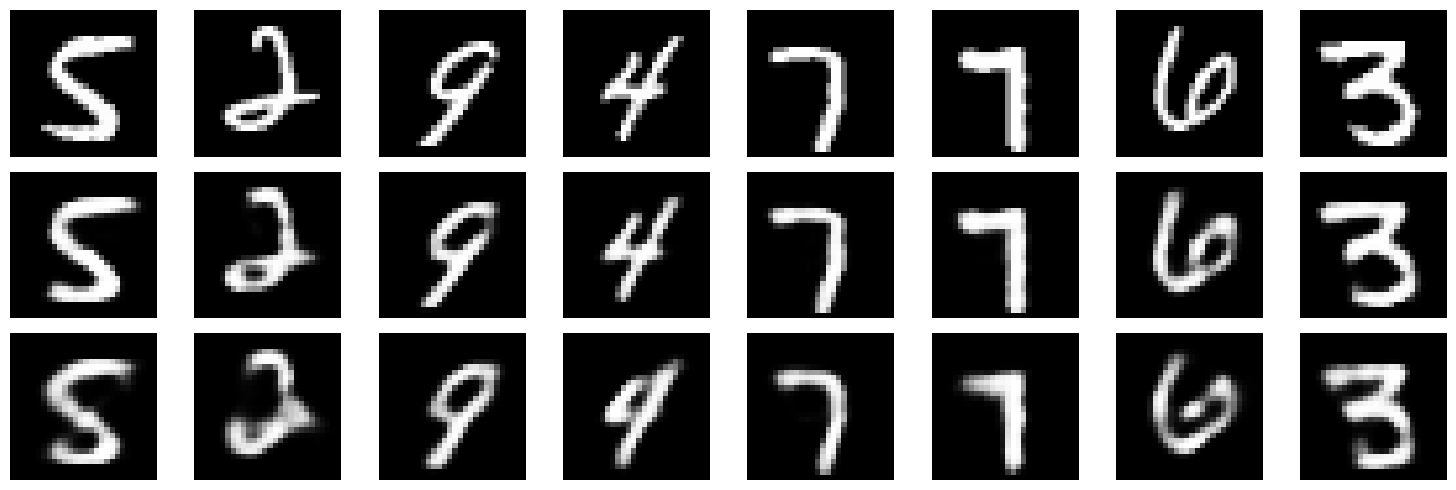

In [ ]:
#Compare Reconstructions
# AE recon
sample = next(iter(train_loader))[0][:8]
sample_flat = sample.view(-1, 28*28)
ae_recon = model(sample_flat).view(-1, 1, 28, 28)

# VAE recon
vae_recon, _, _ = vae(sample_flat)
vae_recon = vae_recon.view(-1, 1, 28, 28)

# Plot
fig, axes = plt.subplots(3, 8, figsize=(15, 5))
for i in range(8):
    axes[0, i].imshow(sample[i][0], cmap='gray'); axes[0, i].axis('off')
    axes[1, i].imshow(ae_recon[i][0].detach().numpy(), cmap='gray'); axes[1, i].axis('off')
    axes[2, i].imshow(vae_recon[i][0].detach().numpy(), cmap='gray'); axes[2, i].axis('off')
axes[0, 0].set_ylabel("Original"); axes[1, 0].set_ylabel("AE"); axes[2, 0].set_ylabel("VAE")
plt.tight_layout()
plt.savefig("reconstructions.png")
plt.show()

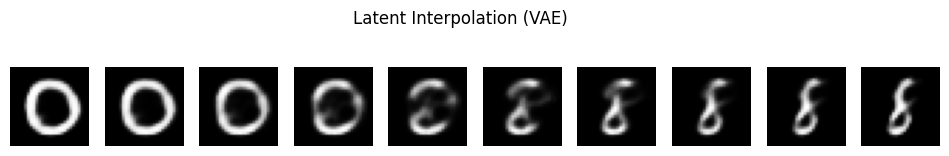

In [ ]:
#PERFORM LATENT VECTOR ARITHMETIC
# Interpolation between two digits
x, _ = next(iter(train_loader))
x1, x2 = x[0].view(-1, 28*28), x[1].view(-1, 28*28)
z1 = vae.reparameterize(*vae.encode(x1))
z2 = vae.reparameterize(*vae.encode(x2))

fig, axes = plt.subplots(1, 10, figsize=(12, 2))
for i, alpha in enumerate(np.linspace(0, 1, 10)):
    z = z1 * (1 - alpha) + z2 * alpha
    recon = vae.decode(z).view(28, 28).detach().numpy()
    axes[i].imshow(recon, cmap='gray'); axes[i].axis('off')
plt.suptitle("Latent Interpolation (VAE)")
plt.show()
